In [1]:
# !pip install scanpy
# !pip install leidenalg

import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import seaborn as sns
import matplotlib.pyplot as plt

sc.settings.verbosity = 0
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/Users/dmnemch/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.26.2 scipy==1.11.4 pandas==1.5.3 scikit-learn==1.1.3 statsmodels==0.14.0 igraph==0.10.8 pynndescent==0.5.11


In [2]:
# copy predicted by Azimuth cell types and load dataset
ground_truth = pd.read_csv('data/azimuth_pred_1k.tsv', delimiter='\t').rename(columns={'predicted.celltype.l2':'label'}).iloc[:, 0:2]
adata = sc.read_10x_mtx('data/1k', var_names='gene_symbols')

In [3]:
# preprocess dataset
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# adata = adata[adata.obs.n_genes_by_counts < 2500, :]
# adata = adata[adata.obs.pct_counts_mt < 5, :]

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]


In [4]:
# copy adata and make regression
adata_noreg = adata.copy()
adata_mtreg = adata.copy()
adata_cntreg = adata.copy()
adata_allreg = adata.copy()

sc.pp.regress_out(adata_mtreg, ['pct_counts_mt'])
sc.pp.regress_out(adata_cntreg, ['total_counts'])
sc.pp.regress_out(adata_allreg, ['total_counts', 'pct_counts_mt'])

adata_noreg.obs['cell'] = adata_noreg.obs_names
adata_noreg.obs = adata_noreg.obs.merge(ground_truth, on='cell')
adata_mtreg.obs['cell'] = adata_mtreg.obs_names
adata_mtreg.obs = adata_mtreg.obs.merge(ground_truth, on='cell')
adata_cntreg.obs['cell'] = adata_cntreg.obs_names
adata_cntreg.obs = adata_cntreg.obs.merge(ground_truth, on='cell')
adata_allreg.obs['cell'] = adata_allreg.obs_names
adata_allreg.obs = adata_allreg.obs.merge(ground_truth, on='cell')

/Users/dmnemch/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/Users/dmnemch/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/Users/dmnemch/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/Users/dmnemch/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    

/Users/dmnemch/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/dmnemch/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


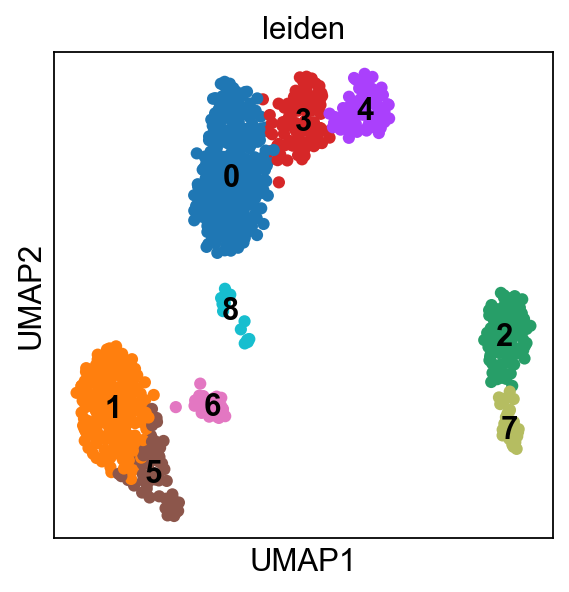

/Users/dmnemch/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/dmnemch/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


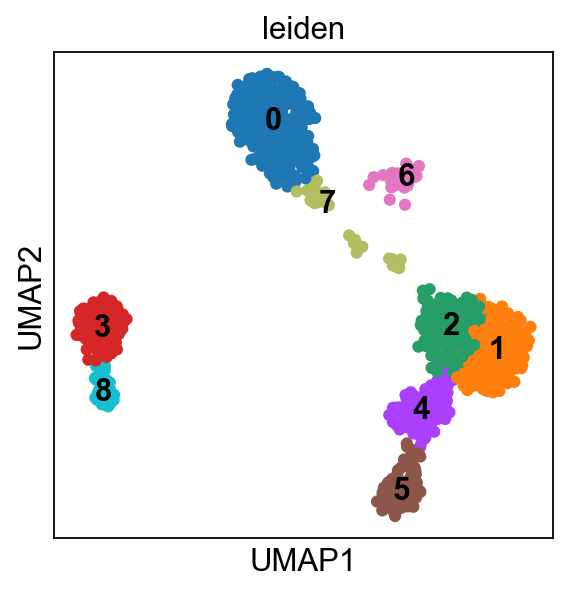

/Users/dmnemch/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/dmnemch/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


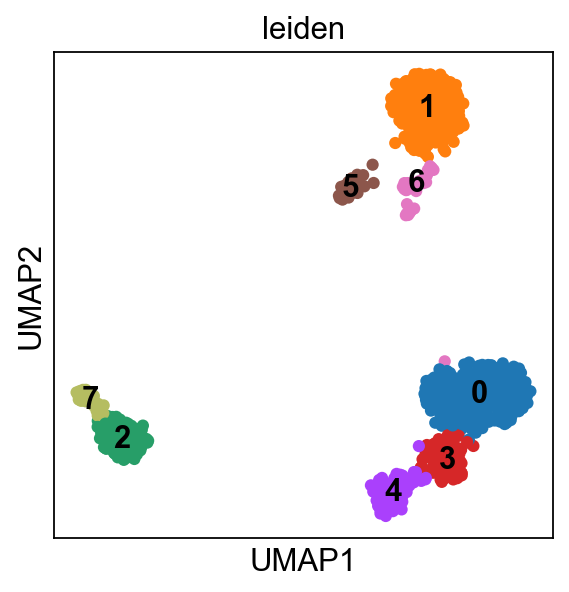

/Users/dmnemch/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/dmnemch/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


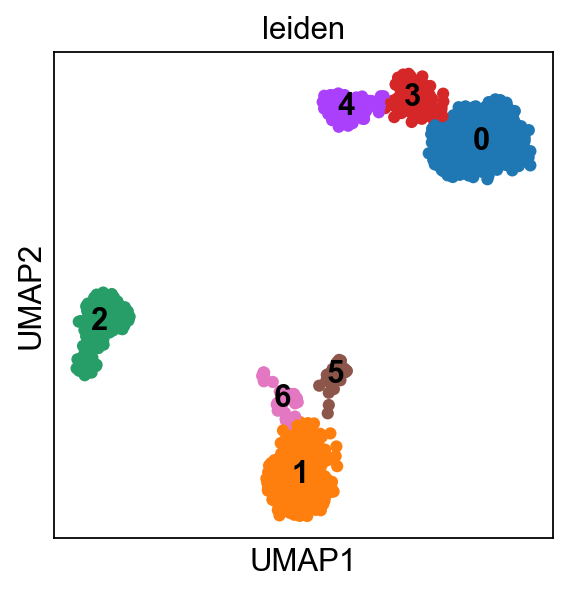

  metric       var  label
0    nmi  0.773858      0
1    ari  0.647728      0
2    nmi  0.779644      1
3    ari  0.732846      1
4    nmi  0.797672      2
5    ari  0.740860      2
6    nmi  0.784784      3
7    ari  0.720241      3


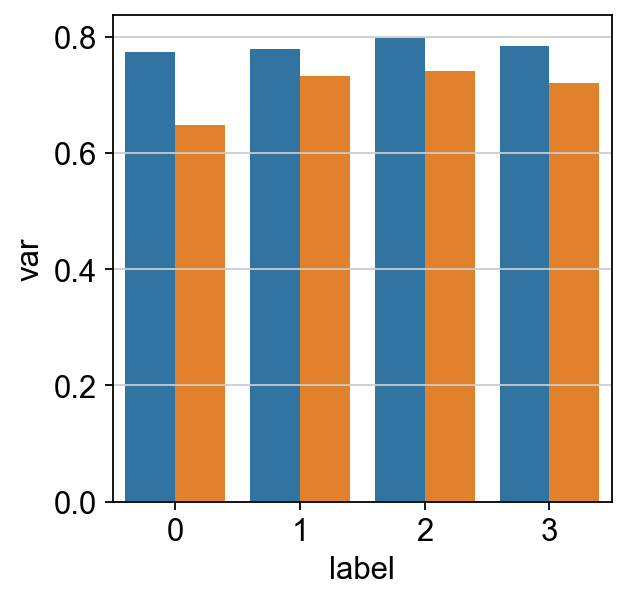

In [5]:
# calculate nmi, ari and plot UMAP for each regression type
df = pd.DataFrame(columns=['metric', 'var', 'label'])
['no_reg', 'mt_reg', 'counts_reg', 'all_reg']
for i, adata in enumerate([adata_noreg, adata_mtreg, adata_cntreg, adata_allreg]):
  sc.pp.scale(adata, max_value=10)
  sc.pp.neighbors(adata, n_neighbors=15)
  sc.tl.leiden(adata)
  nmi = normalized_mutual_info_score(adata.obs['label'], adata.obs['leiden'])
  ari = adjusted_rand_score(adata.obs['label'], adata.obs['leiden'])
  sc.tl.umap(adata)
  sc.pl.umap(adata, color=['leiden'], legend_loc='on data')
  df.loc[len(df.index)] = ['nmi', nmi, i]
  df.loc[len(df.index)] = ['ari', ari, i]
ax = sns.barplot(df, x='label', y='var', hue='metric')
plt.legend([],[], frameon=False)
print(df)